In [1]:
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import re
import time
from tqdm import tqdm
 
import numpy as np
import pandas as pd
 

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from selenium import webdriver

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import *
from bs4 import BeautifulSoup

In [2]:
#Зададим путь к основной папке

path_main = r"/home/g/Desktop/Хакатон на волге/volga_hack"

In [3]:
with open('review.html') as html:
    content = html.read()
    soup = BeautifulSoup(content, "html.parser")

    # Находим все элементы с классом "business-review-view__body-text"
    comments = soup.find_all(class_="business-review-view__body-text")

    # Создаем список для результатов парсинга
    scrapped = []

    # Извлекаем тексты комментариев и добавляем их в список
    for comment in comments:
        scrapped.append(comment.get_text())


In [4]:
print(type(scrapped))

<class 'list'>


In [5]:
import csv

# Открываем файл CSV для записи
with open('comments.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Записываем каждый комментарий в отдельную строку
    for comment in scrapped:
        writer.writerow([comment])

In [6]:
comments_stanok = pd.DataFrame({'comment':scrapped})
comments_stanok.to_csv(path_main + '/comments_stanok.csv')

## Загрузка размеченного датасета study.mokoron
Источник https://study.mokoron.com/

In [7]:
positive = pd.read_csv(path_main + '/russian_sentiment_tweet_automated_labeled/positive.csv',
                       sep = ';',
                       header= None
                      )
negative = pd.read_csv(path_main + '/russian_sentiment_tweet_automated_labeled/negative.csv',
                       sep = ';',
                       header= None
                      )

In [8]:
positive_text = pd.DataFrame(positive.iloc[:, 3])
negative_text = pd.DataFrame(negative.iloc[:, 3])


In [9]:
positive_text['label'] = [1] * positive_text.shape[0]
negative_text['label'] = [0] * negative_text.shape[0]

In [10]:
labeled_tweets = pd.concat([positive_text, negative_text])


In [11]:

labeled_tweets.index = range(labeled_tweets.shape[0])


In [12]:
labeled_tweets.columns = ['text', 'label']
labeled_tweets

text  label
0       @first_timee хоть я и школота, но поверь, у на...      1
1       Да, все-таки он немного похож на него. Но мой ...      1
2       RT @KatiaCheh: Ну ты идиотка) я испугалась за ...      1
3       RT @digger2912: "Кто то в углу сидит и погибае...      1
4       @irina_dyshkant Вот что значит страшилка :D\nН...      1
...                                                   ...    ...
226829  Но не каждый хочет что то исправлять:( http://...      0
226830  скучаю так :-( только @taaannyaaa вправляет мо...      0
226831          Вот и в школу, в говно это идти уже надо(      0
226832  RT @_Them__: @LisaBeroud Тауриэль, не грусти :...      0
226833  Такси везет меня на работу. Раздумываю приплат...      0

[226834 rows x 2 columns]

### Очистка размеченного датасета

Напишем фукнцию для очистки текстов от лишних символов


In [13]:
# Оставим в тексте только кириллические символы
def clear_text(text):
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return " ".join(clear_text.split())

# напишем функцию удаляющую стоп-слова
def clean_stop_words(text, stopwords):
    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)

In [14]:
nltk.download('stopwords')
# загрузим список стоп-слов
stopwords = set(nltk_stopwords.words('russian'))
np.array(stopwords)

[nltk_data] Downloading package stopwords to /home/g/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array({'ее', 'другой', 'впрочем', 'с', 'ей', 'три', 'я', 'тот', 'там', 'как', 'один', 'да', 'над', 'свою', 'есть', 'того', 'будет', 'моя', 'вас', 'когда', 'лучше', 'них', 'такой', 'вам', 'ты', 'до', 'был', 'него', 'куда', 'со', 'ли', 'он', 'у', 'уже', 'все', 'кто', 'больше', 'сейчас', 'этот', 'тут', 'может', 'надо', 'какая', 'то', 'нибудь', 'при', 'мы', 'мой', 'еще', 'чего', 'том', 'нее', 'было', 'им', 'меня', 'ни', 'уж', 'тебя', 'без', 'в', 'по', 'тогда', 'а', 'ну', 'опять', 'вот', 'его', 'но', 'даже', 'между', 'или', 'ним', 'чтобы', 'можно', 'какой', 'они', 'тоже', 'будто', 'хоть', 'никогда', 'во', 'чтоб', 'так', 'этой', 'от', 'раз', 'нет', 'если', 'потом', 'зачем', 'нас', 'здесь', 'ничего', 'эту', 'разве', 'после', 'были', 'не', 'через', 'вы', 'всех', 'теперь', 'иногда', 'ему', 'их', 'быть', 'о', 'что', 'тем', 'про', 'под', 'была', 'нельзя', 'много', 'на', 'и', 'где', 'она', 'всю', 'почти', 'хорошо', 'ж', 'мне', 'совсем', 'из', 'конечно', 'этом', 'чуть', 'потому', 'себе', 'же', 'эти

In [15]:
# Протестируем работу функции очистки текста
text = labeled_tweets['text'][np.random.randint(labeled_tweets.shape[0])]
print(text)
print('=======================================')
print(clean_stop_words((clear_text(text)), stopwords))

Ученье — свет, а неученье — приятный полумрак.. ;-)
ученье свет неученье приятный полумрак


In [16]:
start_clean = time.time()

labeled_tweets['text_clear'] = labeled_tweets['text'].apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 6.11 секунд


In [17]:
labeled_tweets = labeled_tweets[['text_clear', 'label']]
labeled_tweets

text_clear  label
0       школота поверь самое общество профилирующий пр...      1
1                        таки немного похож мальчик равно      1
2                                      идиотка испугалась      1
3       углу сидит погибает голода ещё порции взяли хо...      1
4       значит страшилка блин посмотрев части создастс...      1
...                                                   ...    ...
226829                            каждый хочет исправлять      0
226830                скучаю вправляет мозги равно скучаю      0
226831                               школу говно это идти      0
226832                              тауриэль грусти обнял      0
226833  такси везет работу раздумываю приплатить втащи...      0

[226834 rows x 2 columns]

In [18]:
labeled_tweets.to_csv(path_main + '/labeled_tweets_clean.csv')

## Загрузка размеченного датасета  Linis Crowd
Источник http://www.linis-crowd.org/

In [19]:
labeled_texts_1 = pd.read_excel(
    path_main + '/linis_crowd_dataset/doc_comment_summary.xlsx',
    sheet_name = 0,
    header=None
    )

In [20]:
labeled_texts_1

0   1
0      Но при мужчине ни одна приличная женщина не по...  -1
1      Украина это часть Руси искусственно отделенная...  -1
2      Как можно говорить об относительно небольшой к...  -1
3      1.2014.  а что они со своими поляками сделали?...   0
4      у а фильмы... Зрители любят диковинное.   у ме...   0
...                                                  ...  ..
26868  Многих заставляют. Многие сами проявляют излиш...  -1
26869  Очередной Чубайс.  ну а чего нового то? Сорос ...  -1
26870  Закон, как все предыдущие - абсолютный бред и ...   0
26871  дело которое ты делаешь сейчас - оно очень хор...   0
26872  Рядом с Токио, да, мало пальм :) Зато на Окина...   0

[26873 rows x 2 columns]

In [21]:
labeled_texts_1['label'] = pd.to_numeric(labeled_texts_1.iloc[:, 1], errors='coerce')

In [22]:
labeled_texts_1 = labeled_texts_1[[0, 'label']]

In [23]:
labeled_texts_1.columns = ['text', 'label']

labeled_texts_1.label.value_counts()

label
 0.0        13930
-1.0         9203
 1.0         1795
-2.0         1534
 2.0          365
 22158.0        2
 21887.0        1
 23486.0        1
 23523.0        1
Name: count, dtype: int64

In [24]:
ind_drop = labeled_texts_1.query('label > 2 or label < -2').index

ind_drop

Index([10224, 15325, 15786, 17474, 26375], dtype='int64')

In [25]:
labeled_texts_1 = labeled_texts_1.query('index not in @ind_drop')

In [26]:
for _ in range(4):
    
    sample = labeled_texts_1.sample(n = 1)
    
    print('label: ', sample.label.values[0])
    
    print(sample['text'].values[0][:200]) 
    
    print()

label:  -1.0
ы уроды, и манагеры ваши проститутки, которые не все условия договора говорят, даже если спрашиваешь, а листов в договоре с десяток их хер кто читает.далее нормальным шрифтом.Внимательно читайте то чт

label:  0.0
Подруга скинула ссылку bazy.sq6.ru . Захожу значит туда, вбиваю свои данные, там имя по-моему и фамилию, а и ещё дату рождения если память меня не подводит. Ну так вот и после авторизации на сайте мне

label:  -1.0
Будем надеятся, что поймут это раньше , чем  все разрушат.  Так оно и есть. Жаль. что многие понимают это уже тогда, когда нечего есть.Разрушить то быстро можно, а вот  вернуть все как было... бывает 

label:  -1.0
Культура людей, работающих на земле, лишь по воскресеньям и редким праздникам приходила в клубы сельские с гармошкой, песнями. А какой культуры сейчас не хватает молодым наркоманам? Она вся сосредоточ



In [27]:
selected = labeled_texts_1.query('label != 0')

In [28]:
selected.label.value_counts()

label
-1.0    9203
 1.0    1795
-2.0    1534
 2.0     365
Name: count, dtype: int64

In [29]:
selected.loc[:, 'label_binary'] = np.nan


/tmp/ipykernel_45938/1025937621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected.loc[:, 'label_binary'] = np.nan


In [30]:
selected.label.value_counts()

label
-1.0    9203
 1.0    1795
-2.0    1534
 2.0     365
Name: count, dtype: int64

In [31]:
selected.loc[((selected['label'] == -1) |
         (selected['label'] == -2)), 'label_binary'] = 0
selected.loc[((selected['label'] == 1) |
        (selected['label'] == 2)), 'label_binary'] = 1

In [32]:
selected.label_binary.value_counts()

label_binary
0.0    10737
1.0     2160
Name: count, dtype: int64

In [33]:
for _ in range(3):
    
    sample_neg = selected.query('label_binary == 0').sample(n = 1)
    
    sample_pos = selected.query('label_binary == 1').sample(n = 1)
    
    print('label: ', sample_pos.label_binary.values[0])
    
    print(sample_pos['text'].values[0][:200]) 
    
    print('label: ', sample_neg.label_binary.values[0])
    
    print(sample_neg['text'].values[0][:200]) 
    
    print()

label:  1.0
 встречалась с девушками, которые работают вместе с Толоконниковой, и они утверждают, что никаких конфликтов нет и Толоконникова - нормальный человек , - добавила член ОП. Каннабих отметила, что осужд
label:  0.0
Есть басня со словами : А Васька слушает, да ест.  А вы просто слова преподносите, как целое событие.  Именно так!СМИ надо разгонять, вместе с правительством!  Путен такой Путен: строгий, но справедли

label:  1.0
И непременно восполедуют радостные вопли путинистов, что Светлейший формирует опричнину, которая наконец-то начнет вычищать авгиевы конюшни...  скорее Waffen SS :)   ...личную гвардию для президента В
label:  0.0
ак что попались такие бызнысмены... ну которых спасать и ни к чему ваще - все равно все прокакают. фабрики лозоплетения короче... Тут главное  - не зевнуть, а если есть чо ценное в реальных активах у 

label:  1.0
Или Токио. Да хоть Сингапуру.  Да, и пусть они принимают всякие там транспортные карты и прочие не наличные способы. Только так, нал н

## Лемматизация текстов

In [34]:
start_clean = time.time()

selected['text_clear'] = selected['text']\
                               .apply(lambda x:
                                      clean_stop_words(
                                        clear_text(str(x)),
                                        stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 3.19 секунд


/tmp/ipykernel_45938/3338079758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['text_clear'] = selected['text']\


In [35]:
def lemmatize(df : (pd.Series, pd.DataFrame),
              text_column : (None, str),
              n_samples : int,
              break_str = 'br',
             ) -> pd.Series:
    """
    Принимает:
    df -- таблицу или столбец pandas содержащий тексты,
    text_column -- название столбца указываем если передаем таблицу,
    n_samples -- количество текстов для объединения,
    break_str -- символ разделения, нужен для ускорения,
    количество текстов записанное в n_samples объединяется 
    в одит большой текст с предварительной вставкой символа 
    записанного в break_str между фрагментами
    затем большой текст лемматизируется, после чего разбивается на
    фрагменты по символу break_str
    
    
    Возвращает:
    Столбец pd.Series с лемматизированными текстами
    в которых все слова приведены к изначальной форме:
    * для существительных — именительный падеж, единственное число;
    * для прилагательных — именительный падеж, единственное число,
    мужской род;
    * для глаголов, причастий, деепричастий — глагол в инфинитиве 
    (неопределённой форме) несовершенного вида.
    
    """
    
    result = []
    
    m = Mystem()    
    
    for i in tqdm(range((df.shape[0] // n_samples) + 1)) :
        
        start = i * n_samples
        
        stop = start + n_samples
        
        sample = break_str.join(df[text_column][start : stop].values)
        
        lemmas = m.lemmatize(sample)
        
        lemm_sample = ''.join(lemmas).split(break_str)
        
        result += lemm_sample
        
    return pd.Series(result, index = df.index)

In [36]:
selected['lemm_clean_tex'] = lemmatize(
    df = selected,
    text_column = 'text_clear',
    n_samples = 100,
    break_str = 'br',
    )

100%|██████████| 130/130 [01:04<00:00,  2.03it/s]
/tmp/ipykernel_45938/959808114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['lemm_clean_tex'] = lemmatize(


In [37]:
labeled_tweets['lemm_text_clear'] = lemmatize(
    df = labeled_tweets,
    text_column = 'text_clear',
    n_samples = 1000,
    break_str = 'br',
    )

100%|██████████| 227/227 [00:58<00:00,  3.90it/s]


In [38]:
labeled_tweets

text_clear  label  \
0       школота поверь самое общество профилирующий пр...      1   
1                        таки немного похож мальчик равно      1   
2                                      идиотка испугалась      1   
3       углу сидит погибает голода ещё порции взяли хо...      1   
4       значит страшилка блин посмотрев части создастс...      1   
...                                                   ...    ...   
226829                            каждый хочет исправлять      0   
226830                скучаю вправляет мозги равно скучаю      0   
226831                               школу говно это идти      0   
226832                              тауриэль грусти обнял      0   
226833  такси везет работу раздумываю приплатить втащи...      0   

                                          lemm_text_clear  
0       школоть поверять самый общество профилировать ...  
1                      таки немного похожий мальчик равно  
2                                      идиотка испугалась  
3       углу сидеть погибать голод еще порция взять хо...  
4       значит страшилка блин посмотреть часть создава...  
...                                                   ...  
226829                           каждый хотеть исправлять  
226830               скучаю вправлять мозги равный скучаю  
226831                               школу гавно это идти  
226832                              тауриэль грусть обнял  
226833  такси везти работа раздумывать приплачивать вт...  

[226834 rows x 3 columns]

## Объединение двух наборов текстов

In [39]:
sample_1 = labeled_tweets[['text_clear', 'lemm_text_clear', 'label']]

sample_2 = selected[['text_clear', 'lemm_clean_tex', 'label_binary']]

sample_2.columns = ['text_clear','lemm_text_clear', 'label']

sample_2.isna().sum()


text_clear          0
lemm_text_clear     0
label              41
dtype: int64

In [40]:
sample_2 = sample_2.dropna()
sample_2.isna().sum()

text_clear         0
lemm_text_clear    0
label              0
dtype: int64

In [41]:
joned_text = pd.concat([sample_1, sample_2])

In [42]:
joned_text

text_clear  \
0      школота поверь самое общество профилирующий пр...   
1                       таки немного похож мальчик равно   
2                                     идиотка испугалась   
3      углу сидит погибает голода ещё порции взяли хо...   
4      значит страшилка блин посмотрев части создастс...   
...                                                  ...   
26864  великое испытание выпало долю наших предков ве...   
26865  н своему поведению крайне низкий человек прост...   
26866  многие психологические книги кричат женщины да...   
26868  многих заставляют многие сами проявляют излишн...   
26869  очередной чубайс нового сорос х дал исчерпываю...   

                                         lemm_text_clear  label  
0      школоть поверять самый общество профилировать ...    1.0  
1                     таки немного похожий мальчик равно    1.0  
2                                     идиотка испугалась    1.0  
3      углу сидеть погибать голод еще порция взять хо...    1.0  
4      значит страшилка блин посмотреть часть создава...    1.0  
...                                                  ...    ...  
26864  великое испытание выпадать доля наш предок веч...    1.0  
26865  н свой поведение крайне низкий человек прощать...    0.0  
26866  многие психологический книга кричать женщина д...    1.0  
26868  многих заставлять многий сам проявлять излишни...    0.0  
26869  очередной чубайс новый сорос х давать исчерпыв...    0.0  

[239731 rows x 3 columns]

In [43]:
joned_text.label.value_counts()


label
0.0    122660
1.0    117071
Name: count, dtype: int64

In [44]:
joned_text.columns = ['text', 'lemm_text', 'label']

In [45]:
joned_text.index = range(joned_text.shape[0])

In [46]:
joned_text.isna().sum()

text         0
lemm_text    0
label        0
dtype: int64

In [47]:
joned_text = joned_text.dropna()
joned_text.isna().sum()

text         0
lemm_text    0
label        0
dtype: int64

## Получение TF-IDF векторных представлений размеченных текстов

Для обучения классификатора получим значения IDF (inference document frequency) для слов из тренировочного набора данных, значения IDF равны логарифму отношения количества документов к количеству документов содержащих искомое слово. Например для стандартных слов, которые встречаются практически в любом тексте IDF будет близок к единице, а для специфичных, которые встречаются в одном тексте из 100 это значение будет равно уже 2 (если мы берем основание логарифма 10).

Затем получив словарь со значениями IDF мы можем получить векторное представление каждого текста по следующему принципу, значения IDF слова умножаем на значения

In [48]:
sample_2.columns = ['text', 'text_lemm', 'label']
sample_1.columns = ['text', 'text_lemm', 'label']

In [49]:
# предварительно разделим выборку на тестовую и обучающую
train, test = train_test_split(sample_1,
                        test_size = 0.2,
                        random_state = 12348,
                       )

print(train.shape)
print(test.shape)

(181467, 3)
(45367, 3)


In [50]:
# Сравним распределение целевого признака
for sample in [train, test]:    
    print(sample[sample['label'] == 1].shape[0] / sample.shape[0])

0.5066265491797407
0.5064253752727753


In [51]:
count_idf_positive = TfidfVectorizer(ngram_range = (1,1))
count_idf_negative = TfidfVectorizer(ngram_range = (1,1))

tf_idf_positive = count_idf_positive.fit_transform(train.query('label == 1')['text'])
tf_idf_negative = count_idf_negative.fit_transform(train.query('label == 0')['text'])

In [52]:
# Сохраним списки Idf для каждого класса
positive_importance = pd.DataFrame(
    {'word' : count_idf_positive.get_feature_names_out(),
     'idf' : count_idf_positive.idf_
    }).sort_values(by = 'idf', ascending = False)

negative_importance = pd.DataFrame(
    {'word' : count_idf_negative.get_feature_names_out(),
     'idf' : count_idf_negative.idf_
    }).sort_values(by = 'idf', ascending = False)

In [53]:
positive_importance.query('word not in @negative_importance.word and idf < 10.8')

word        idf
34257               клал  10.637099
56843           отпуском  10.637099
57541         охрененный  10.637099
55852  ответныйфолловинг  10.637099
56045          отдельную  10.637099
...                  ...        ...
70829          продолжай   9.209983
93370           улыбнуло   8.667659
53367       оглядываются   8.557658
73605       разблокируют   8.537039
74470              ракал   7.576829

[1190 rows x 2 columns]

In [54]:
negative_importance.query('word not in @positive_importance.word and idf < 10')

word       idf
30801               красноярцы  9.917445
8270                взорвалась  9.917445
40278                 начаться  9.917445
74891                 терактов  9.917445
58453               прискорбно  9.917445
...                        ...       ...
68023                  скорбим  8.595689
52192                 погибших  8.395018
41110                 некролог  8.359300
74888                   теракт  8.308007
69215  снаступающимтвиттерский  8.111892

[103 rows x 2 columns]

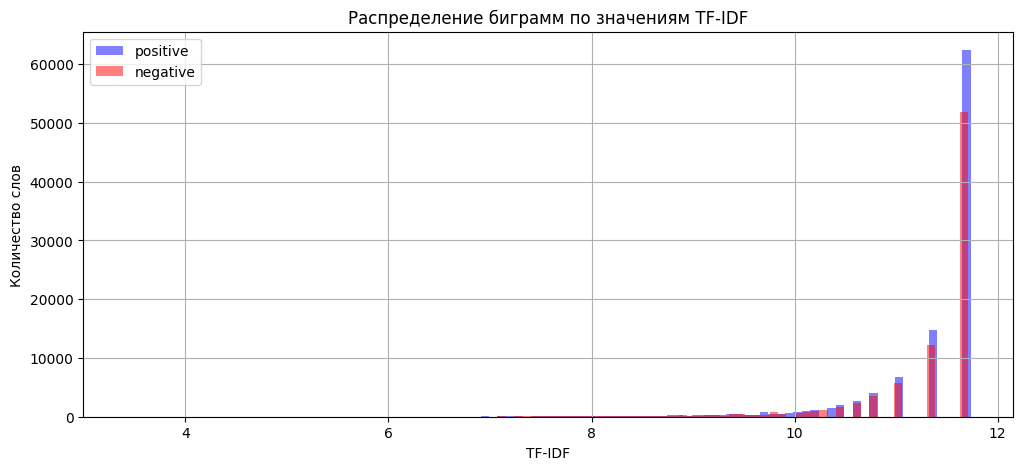

In [55]:
fig = plt.figure(figsize = (12,5))
positive_importance.idf.hist(bins = 100,
                             label = 'positive',
                             alpha = 0.5,
                             color = 'b',
                            )
negative_importance.idf.hist(bins = 100,
                             label = 'negative',
                             alpha = 0.5,
                             color = 'r',
                            )
plt.title('Распределение биграмм по значениям TF-IDF')
plt.xlabel('TF-IDF')
plt.ylabel('Количество слов')
plt.legend()
plt.show()

## Предварительное обучение моделей

In [56]:
# Получим векторные представления текстов\
count_idf_1 = TfidfVectorizer(ngram_range=(1,1))

In [57]:
tf_idf_base_1 = count_idf_1.fit(sample_1['text'])
tf_idf_train_base_1 = count_idf_1.transform(train['text'])
tf_idf_test_base_1 = count_idf_1.transform(test['text'])

In [58]:
model_lr_base_1 = LogisticRegression(solver = 'lbfgs',
                                    random_state = 12345,
                                    max_iter= 10000,
                                    n_jobs= -1)

In [59]:
model_lr_base_1.fit(tf_idf_train_base_1, train['label'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

In [60]:
predict_lr_base_proba = model_lr_base_1.predict_proba(tf_idf_test_base_1)

### Сравнение качества классификации на лемматизированных текстах


In [61]:
# Получим векторные представления лемматизированных текстов
count_idf_lemm = TfidfVectorizer(ngram_range=(1,1))

In [62]:
tf_idf_lemm = count_idf_lemm.fit(sample_1['text_lemm'])
tf_idf_train_lemm = count_idf_lemm.transform(train['text_lemm'])
tf_idf_test_lemm = count_idf_lemm.transform(test['text_lemm'])

In [63]:
model_lr_lemm = LogisticRegression(solver = 'lbfgs',
                                    random_state = 12345,
                                    max_iter= 10000,
                                    n_jobs= -1)

In [64]:
model_lr_lemm.fit(tf_idf_train_lemm, train['label'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

In [65]:
predict_lr_lemm_proba = model_lr_lemm.predict_proba(tf_idf_test_lemm)

In [66]:
def coin_classifier(X:np.array) -> np.array:
    predict = np.random.uniform(0.0, 1.0, X.shape[0])
    return predict

In [67]:
coin_predict = coin_classifier(tf_idf_test_base_1)

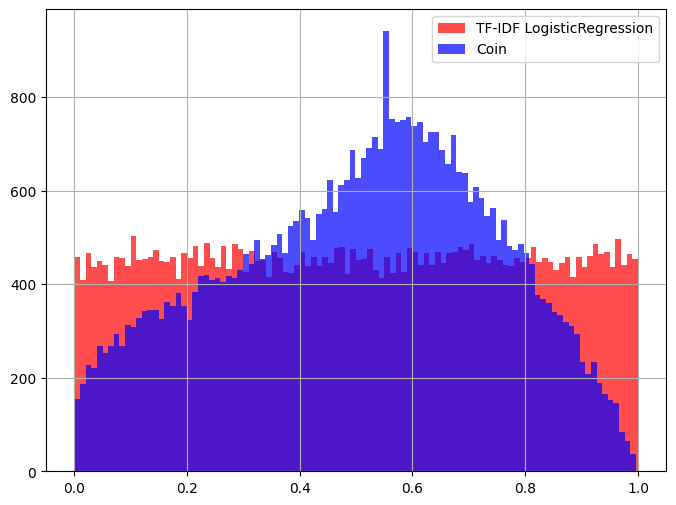

In [68]:
fif = plt.figure(figsize = (8, 6))

pd.Series(coin_predict)\
                .hist(bins = 100,
                      alpha = 0.7,
                      color = 'r',
                      label = 'TF-IDF LogisticRegression'
                     )

pd.Series(predict_lr_base_proba[:, 1])\
                .hist(bins = 100,
                      alpha = 0.7,
                      color = 'b',
                      label = 'Coin'
                     )
plt.legend()   
plt.show()

### Визуализация важности признаков

In [69]:
# Получим веса признаков, то есть множители 
# подобранные логистической регрессией 
# для каждого компонента вектора tf-idf

weights = pd.DataFrame({'words': count_idf_1.get_feature_names_out(),
                        'weights': model_lr_base_1.coef_.flatten()})
weights_min = weights.sort_values(by= 'weights')
weights_max = weights.sort_values(by= 'weights', ascending = False)

In [70]:
weights_min = weights_min[:100]
weights_min['weights'] = weights_min['weights'] * -1
weights_min

words   weights
85419     обидно  6.913103
28964    грустно  6.084366
39067       жаль  6.079559
98823   печально  5.833986
132462    скучаю  5.404337
...          ...       ...
165003    шерлок  2.627262
150793    уехала  2.616252
27141     голова  2.614374
131999   скорбим  2.602910
116214   пропала  2.560679

[100 rows x 2 columns]

In [71]:
weights_max = weights_max[:100]
weights_max

words   weights
5503           ахаха  4.534309
5502            ахах  4.350795
86118         обожаю  4.257824
20898      вромайдан  4.250785
5539          ахахах  4.214947
...              ...       ...
123673    рекомендую  2.029361
152732        ураааа  2.025813
67727         майдан  2.022084
134420          снов  2.014394
110976  предвкушении  2.011425

[100 rows x 2 columns]

In [72]:
# Воспользуемся библиотекой wordcloud для генерации картинок

wordcloud_positive = WordCloud(background_color="white",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_max.values))

wordcloud_negative = WordCloud(background_color="black",
                               colormap = 'Reds',
                               max_words=200,
                               mask=None, 
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_min.values))

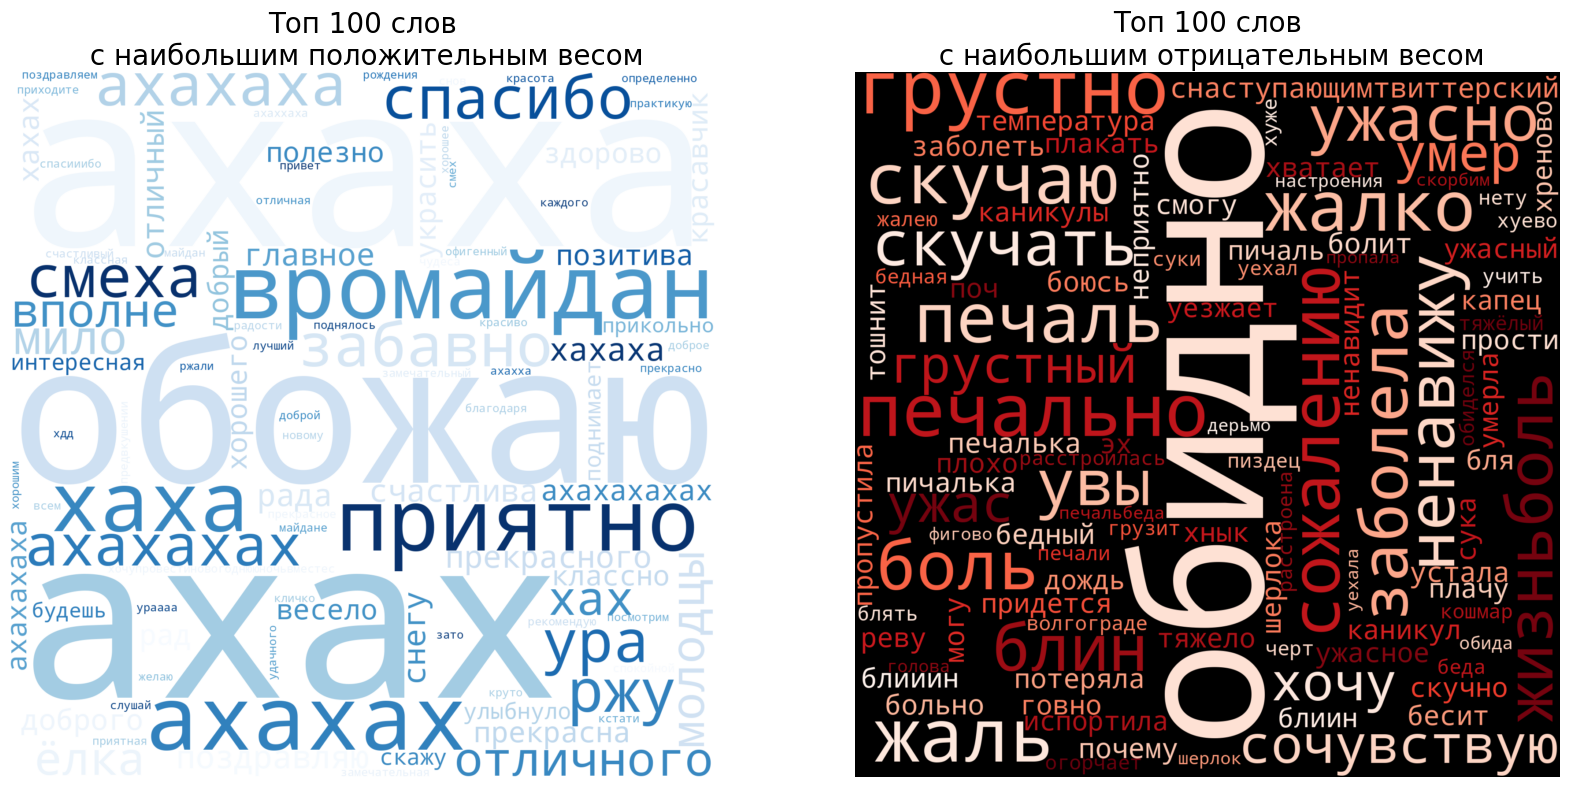

In [73]:
# Выведем картинки сгенерированные вордклаудом
fig, ax = plt.subplots(1, 2, figsize = (20, 12))


ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[1].imshow(wordcloud_negative, interpolation='bilinear')

ax[0].set_title('Топ ' +\
                str(weights_max.shape[0]) +\
                ' слов\n с наибольшим положительным весом',
               fontsize = 20
               )
ax[1].set_title('Топ ' +\
                str(weights_min.shape[0]) +\
                ' слов\n с наибольшим отрицательным весом',
               fontsize = 20
               )

ax[0].axis("off")
ax[1].axis("off")

plt.show()

### Снижение размерности признакового пространства модели


In [74]:
fig = make_subplots(1,1)

fig.add_trace(go.Histogram(
    x = weights.query('weights != 0')['weights'],
    #histnorm = 'probability',
    opacity = 0.5,
    showlegend = False
))

fig.add_trace(go.Histogram(
    x = weights.query('weights > 0.25 or weights < -0.25')['weights'],
    #histnorm = 'probability',
    opacity = 0.5,
    showlegend = False
))

fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    template = 'plotly_dark',
    font_color = 'rgba(212, 210, 210, 1)'
    
)

In [75]:
vocab = weights.query('weights > 0.25 or weights < -0.25')['words']

In [76]:
count_idf = TfidfVectorizer(vocabulary=vocab,
                            ngram_range=(1,1))

In [77]:
tf_idf = count_idf.fit_transform(joned_text['text'])

tf_idf_train = count_idf.transform(train['text'])
tf_idf_test = count_idf.transform(test['text'])

In [78]:
model_lr_base = LogisticRegression(solver = 'lbfgs',
                                    random_state = 12345,
                                    max_iter= 10000,
                                    n_jobs= -1)

In [79]:
model_lr_base.fit(tf_idf_train, train['label'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

In [80]:
predict_lr_base_proba_1 = model_lr_base.predict_proba(tf_idf_test)

In [81]:
fpr_base_1, tpr_base_1, _ = roc_curve(test['label'], predict_lr_base_proba_1[:, 1])
roc_auc_base_1 = auc(fpr_base_1, tpr_base_1)

### Подбор оптимального порогового значения классификации

In [82]:
scores = {}

weight = 0.55

for threshold in np.linspace(0, 1, 100):
    
    matrix = confusion_matrix(test['label'],
                 (predict_lr_base_proba[:, 0] <  threshold).astype('float'),
                 normalize='true',
                )

    score = matrix[0,0] * weight + matrix[1,1] * (1 - weight)
    
    scores[threshold] = score
    

In [83]:
pd.DataFrame({'true_score':scores.values(),
             'threshold':scores.keys()},
             ).sort_values(by = 'true_score', ascending = False).head()

true_score  threshold
44    0.733457   0.444444
45    0.733021   0.454545
46    0.732878   0.464646
43    0.732444   0.434343
47    0.731603   0.474747

In [84]:
matrix = confusion_matrix(test['label'],
                 (predict_lr_base_proba[:, 0] <  0.444444).astype('int'),
                 normalize='true',
                )
matrix

array([[0.77630404, 0.22369596],
       [0.31891186, 0.68108814]])

## Классификация не размеченных комментариев

C помощью обученных tf-idf векторизатора и логистической регрессии получим оценки вероятности негатива в каждом из комментариев

In [85]:
# очистим тексты комментариев под первым видео
start_clean = time.time()

comments_stanok['text_clear'] = comments_stanok['comment']\
                                .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 0.01 секунд


In [86]:
comments_stanok

comment  \
0    Нет никакой смотровой площадки тут, если кто т...   
1    Не стоит идти если хочешь прилично провести вр...   
2    Место не очень, охранники максимально неадеква...   
3    очень маленькое место, а народ курит везде не ...   
4    Курят внутри, на столах стоят пепельницы. Куйб...   
..                                                 ...   
130  Такого в Самаре еще не было) Атмосферное прост...   
131  Недавно открылся бар Куйбышев. Обязателен к по...   
132        Очень уютное и красиво там,стильно и модно.   
133  Заведения,  тусовка,  бары, движуха - вот так ...   
134                                             Круто    

                                            text_clear  
0    никакой смотровой площадки видами сюда собралс...  
1    стоит идти хочешь прилично провести время спок...  
2    место очень охранники максимально неадекватные...  
3    очень маленькое место народ курит везде продох...  
4    курят внутри столах стоят пепельницы куйбышевб...  
..                                                 ...  
130  такого самаре атмосферное пространство котором...  
131  недавно открылся бар куйбышев обязателен посещ...  
132                 очень уютное красиво стильно модно  
133  заведения тусовка бары движуха описала станкоз...  
134                                              круто  

[135 rows x 2 columns]

### Визуализация ключевых слов

In [87]:
stanok_counter = CountVectorizer(ngram_range=(1, 1))

In [88]:
stanok_count = stanok_counter.fit_transform(comments_stanok['text_clear'])

In [89]:
stanok_count.toarray().sum(axis = 0).shape

(1033,)

In [92]:
stanok_counter.get_feature_names_out().shape

(1033,)

In [93]:
# Сохраним списки Idf для каждого класса
stanok_frequence = pd.DataFrame(
    {'word' : stanok_counter.get_feature_names_out(),
     'frequency' : stanok_count.toarray().sum(axis = 0)
    }).sort_values(by = 'frequency', ascending = False)
display(stanok_frequence.shape[0])

1033

In [94]:
wordcloud_stanok = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(stanok_frequence.values))

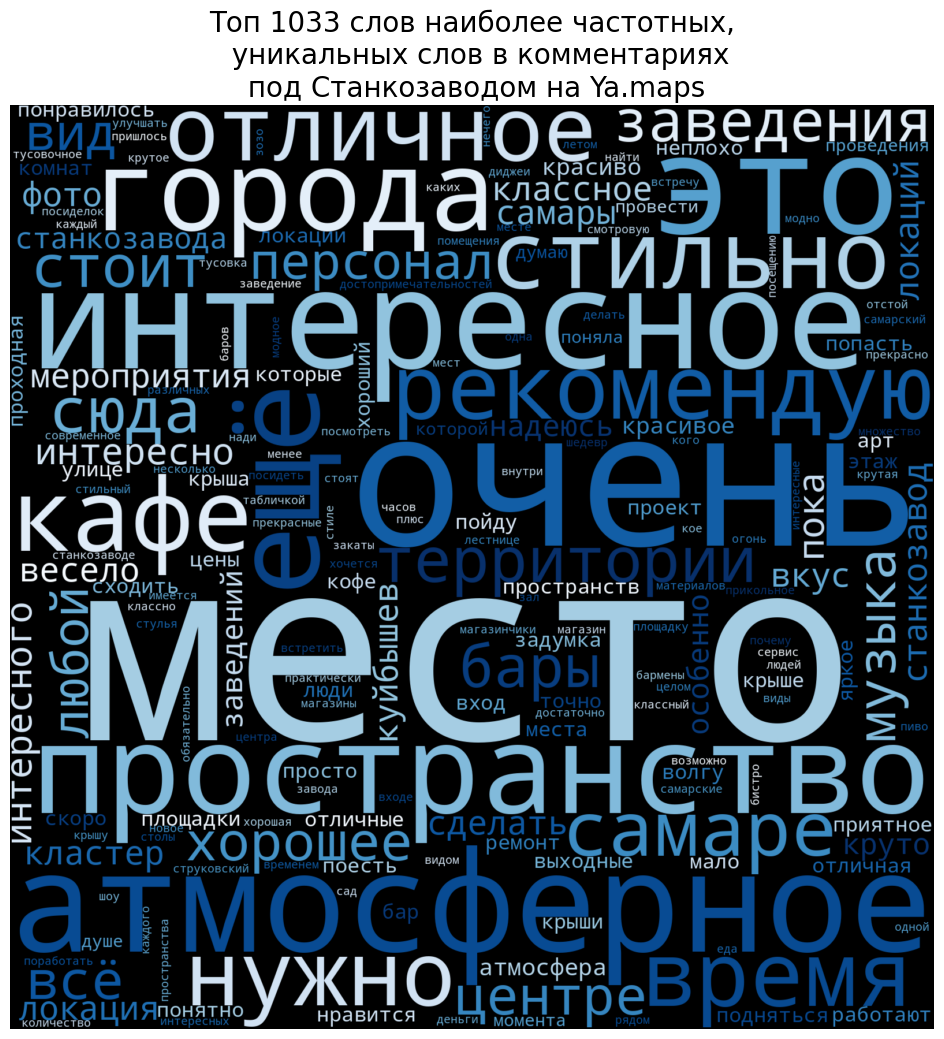

In [101]:
# Выведем картинки сгенерированные вордклаудом
fig, ax = plt.subplots(figsize = (20, 12))


ax.imshow(wordcloud_stanok, interpolation='bilinear')

ax.set_title('Топ ' +\
                str(stanok_frequence.shape[0]) +\
                ' слов наиболее частотных,\n ' +\
                ' уникальных слов в комментариях\n' +\
                ' под Станкозаводом на Ya.maps',
               fontsize = 20
               )

ax.axis("off")

plt.show()

In [107]:
comments_stanok

comment  \
0    Нет никакой смотровой площадки тут, если кто т...   
1    Не стоит идти если хочешь прилично провести вр...   
2    Место не очень, охранники максимально неадеква...   
3    очень маленькое место, а народ курит везде не ...   
4    Курят внутри, на столах стоят пепельницы. Куйб...   
..                                                 ...   
130  Такого в Самаре еще не было) Атмосферное прост...   
131  Недавно открылся бар Куйбышев. Обязателен к по...   
132        Очень уютное и красиво там,стильно и модно.   
133  Заведения,  тусовка,  бары, движуха - вот так ...   
134                                             Круто    

                                            text_clear  
0    никакой смотровой площадки видами сюда собралс...  
1    стоит идти хочешь прилично провести время спок...  
2    место очень охранники максимально неадекватные...  
3    очень маленькое место народ курит везде продох...  
4    курят внутри столах стоят пепельницы куйбышевб...  
..                                                 ...  
130  такого самаре атмосферное пространство котором...  
131  недавно открылся бар куйбышев обязателен посещ...  
132                 очень уютное красиво стильно модно  
133  заведения тусовка бары движуха описала станкоз...  
134                                              круто  

[135 rows x 2 columns]

In [125]:
stanok_tf_idf = count_idf.transform(comments_stanok['text_clear'])


putin_negative_proba = model_lr_base.predict_proba(stanok_tf_idf)


comments_stanok['negative_proba'] = putin_negative_proba[:, 0]


In [126]:
comments_stanok

comment  \
0    Нет никакой смотровой площадки тут, если кто т...   
1    Не стоит идти если хочешь прилично провести вр...   
2    Место не очень, охранники максимально неадеква...   
3    очень маленькое место, а народ курит везде не ...   
4    Курят внутри, на столах стоят пепельницы. Куйб...   
..                                                 ...   
130  Такого в Самаре еще не было) Атмосферное прост...   
131  Недавно открылся бар Куйбышев. Обязателен к по...   
132        Очень уютное и красиво там,стильно и модно.   
133  Заведения,  тусовка,  бары, движуха - вот так ...   
134                                             Круто    

                                            text_clear  negative_proba  
0    никакой смотровой площадки видами сюда собралс...        0.218912  
1    стоит идти хочешь прилично провести время спок...        0.242343  
2    место очень охранники максимально неадекватные...        0.503357  
3    очень маленькое место народ курит везде продох...        0.237249  
4    курят внутри столах стоят пепельницы куйбышевб...        0.348882  
..                                                 ...             ...  
130  такого самаре атмосферное пространство котором...        0.554621  
131  недавно открылся бар куйбышев обязателен посещ...        0.172448  
132                 очень уютное красиво стильно модно        0.081755  
133  заведения тусовка бары движуха описала станкоз...        0.500938  
134                                              круто        0.101814  

[135 rows x 3 columns]

In [135]:
stanok_share_neg = (comments_stanok['negative_proba'] > 0.44).sum() / comments_stanok.shape[0]
stanok_share_neg

0.1259259259259259

In [136]:
comments_stanok[comments_stanok['negative_proba'] > 0.56]

comment  \
6   Делать нечего на станкозаводе(( заведения отст...   
11  пока там делать особо нечего, заведений мало, ...   
17                              Пока что там пусто)))   
22                          У этого места все впереди   

                                           text_clear  negative_proba  
6   делать нечего станкозаводе заведения отстой ед...        0.872744  
11  пока делать особо нечего заведений мало закрыт...        0.774908  
17                                         пока пусто        0.736541  
22                                      места впереди        0.564607

In [139]:
fig = make_subplots(1,1,
                   subplot_titles=['Распределение комментариев по оценке негативности']     
                   )

fig.add_trace(go.Violin(
    x = comments_stanok['negative_proba'],
    meanline_visible = True,
    name = 'Shulman (N = %i)' % comments_stanok.shape[0],
    side = 'positive',
    spanmode = 'hard'
))




fig.add_annotation(x=0.8, y=1.5,
            text = "%0.2f — доля негативных комментариев (при p > 0.44)"\
                   % stanok_share_neg,
            showarrow=False,
            yshift=10)


fig.update_traces(orientation='h', 
                  width = 1.5,
                  points = False
                 )


fig.update_layout(height = 500,
                  #xaxis_showgrid=False,
                  xaxis_zeroline=False,
                  template = 'plotly_dark',
                  font_color = 'rgba(212, 210, 210, 1)',
                  legend=dict(
                    y=0.9,
                    x=-0.1,
                    yanchor='top',
                    ),
                 )
fig.update_yaxes(visible = False)
              


fig.show()